Autor: **Osvaldo L. Santos-Pereira**

🌐 Webpage: https://ozsp12.github.io/  
✅ GitHub: https://github.com/ozsp12  
🧪 ResearchGate: https://www.researchgate.net/profile/Osvaldo-Santos-Pereira  
🔬 Google Scholar: https://scholar.google.com/citations?user=HIZp0X8AAAAJ&hl=en  
🧾 ORCID: https://orcid.org/0000-0003-2231-517X  
💼 LinkedIn: https://www.linkedin.com/in/ozsp12  
🧡 Patreon: https://www.patreon.com/ozsp12  
✍️ Medium: https://medium.com/@ozsp12  
𝕏 X (Twitter): https://x.com/ozsp12  
📱 TikTok: https://www.tiktok.com/@ozsp12  
▶️ YouTube: https://www.youtube.com/@ozlsp12  

# Apply vs. np.select no Pandas: uma análise quantitativa de performance

Em ciência de dados, escolhas na implementação de código podem ter impactos na eficiência de esteiras analíticas. Uma dessas escolhas recorrentes é entre utilizar o método .apply() com funções definidas linha a linha ou optar por abordagens vetorizadas como numpy.select(). Embora ambas conduzam ao mesmo resultado lógico, o custo computacional entre elas pode ser distinto, especialmente em grandes volumes de dados.

Neste experimento, foi conduzida uma avaliação sistemática de performance comparando essas duas abordagens, aplicando uma lógica de classificação sobre um conjunto de dados com diferentes comprimentos (N). O experimento consistiu em atribuir uma categoria a cada valor da coluna Value, de acordo com faixas numéricas: valores acima de 1000 seriam classificados como "High", entre 501 e 1000 como "Medium", e até 500 como "Low".

A primeira abordagem utilizou o método .apply(), que aplica uma função Python sobre cada linha do DataFrame. Essa técnica opera sob uma lógica iterativa interna, típica do interpretador Python, que ignora as otimizações vetoriais do NumPy e do Pandas. Como resultado, seu desempenho degrada severamente à medida que o volume de dados cresce.

A segunda abordagem empregou a função numpy.select(), uma técnica vetorizada que avalia todas as condições de uma só vez, em blocos. Essa estratégia se alinha à arquitetura do Pandas, que é construída sobre arrays NumPy otimizados em C. Por isso, oferece ganhos substanciais de performance, sobretudo quando aplicada a datasets com milhões de registros.

Os testes foram realizados em DataFrames com tamanhos variando de centenas a um milhão de linhas. Em cada cenário, o tempo de execução foi medido para ambas as abordagens. Algumas ressalvas do experimento, devido à problemas de memória, não foi possível realizar o test com N maior que 10^6 linhas, e nesta escala de testes, os dois métodos se mostraram com performance estatisticamente semelhantes. Talvez em uma escala maior (N >> 10^6) a hipótese de que o método do Numpy tenha de fato uma performance melhor.

Abaixo o gráfico demonstrando o resultado do teste, e o código do experimento

# Class

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings

# Desabilita todos os warnings para evitar ruído visual
warnings.filterwarnings("ignore")

# Gera um DataFrame sintético com uma coluna 'Value' contendo inteiros aleatórios.
# n_rows controla o tamanho; seed garante reprodutibilidade.
def generate_dataframe(n_rows: int = 1_000_000, seed: int = 42) -> pd.DataFrame:
    np.random.seed(seed)
    return pd.DataFrame({'Value': np.random.randint(0, 2000, size=n_rows)})

# Função 1: aplica a classificação via apply(), retornando o DF
def run_apply_example(df: pd.DataFrame) -> pd.DataFrame:

    def classify(value: int) -> str:
        if value > 1000:
            return 'High'
        elif value > 500:
            return 'Medium'
        else:
            return 'Low'

    df = df.copy()
    df['FeatFilter'] = df['Value'].apply(classify)
    return df

# Função 2: aplica a mesma classificação, só que via np.select()
def run_select_example(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    conditions = [
        df['Value'] > 1000,
        df['Value'] > 500
    ]
    choices = ['High', 'Medium']

    df['FeatFilter'] = np.select(conditions, choices, default='Low')
    return df

# Método baseado em apply(), chamando uma função Python para cada elemento.
# Notoriamente lento em grandes volumes, pois quebra o vetor (loop implícito em Python).
def method_apply(df: pd.DataFrame) -> float:
    # Função de classificação simples, chamada para cada valor.
    def classify(value: int) -> str:
        if value > 1000:
            return 'High'
        elif value > 500:
            return 'Medium'
        else:
            return 'Low'

    start = time.perf_counter()         # Marca o tempo inicial.
    df['FeatFilter'] = df['Value'].apply(classify)  # Aplica função elemento a elemento.
    return time.perf_counter() - start  # Tempo de execução.

# Método vetorizado usando np.select(), muito mais rápido pois evita Python puro.
def method_np_select(df: pd.DataFrame) -> float:
    start = time.perf_counter()

    # Lista de condições Booleanas, avaliadas em vetor.
    conditions = [
        df['Value'] > 1000,
        df['Value'] > 500
    ]

    # Valores atribuídos conforme a ordem das condições.
    choices = ['High', 'Medium']

    # np.select aplica as regras de forma vetorizada.
    df['FeatFilter'] = np.select(conditions, choices, default='Low')

    return time.perf_counter() - start

# Função que roda benchmarks para diferentes tamanhos de DataFrames
# e plota a comparação do tempo do apply() vs np.select().
def benchmark_plot_apply_vs_npselect(
    sizes = [10**1, 10**2, 10**3, 10**4, 10**5, 10**6],
    figsize=(10, 6),
    log_scale=True
):
    apply_times = []
    npselect_times = []

    # Itera sobre cada tamanho, gera os DataFrames e mede os tempos.
    for n in sizes:
        df = generate_dataframe(n)
        apply_times.append(method_apply(df.copy()))         # .copy() para isolar cada teste.
        npselect_times.append(method_np_select(df.copy()))

    plt.figure(figsize=figsize)

    # Curvas dos tempos de execução.
    plt.plot(sizes, apply_times, marker='o', label='apply()')
    plt.plot(sizes, npselect_times, marker='s', label='np.select()', linestyle='--')

    plt.title("Execution Time vs. Data Size")
    plt.xlabel("Number of Rows (N)")
    plt.ylabel("Execution Time (seconds)")

    # Escala log ajuda a visualizar diferenças de ordem de grandeza.
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\osval\anaconda3\envs\Oz\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\osval\anaconda3\envs\Oz\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Método apply()

O método apply() do Pandas permite aplicar uma função Python sobre cada elemento de uma Series ou sobre cada linha/coluna de um DataFrame. Quando usado em uma coluna, ele funciona como um loop implícito: para cada valor, chama a função e retorna o resultado. É simples e flexível, mas não é vetorizado, portanto é mais lento que operações usando NumPy (np.where, np.select) ou funções nativas do Pandas (map, cut). Use apply() quando a lógica for específica demais para ser vetorizada; evite quando estiver lidando com grandes volumes ou regras simples.

In [ ]:
# gera o dataframe de exemplo para aplicação do método apply()
df1 = pd.DataFrame({'x': [1, 2, 3, 4]})
# mostra o dataframe
df1

O código define uma função simples, quadrado(v), que devolve v * v. Em seguida, essa função é aplicada à coluna x do DataFrame usando df['x'].apply(quadrado). O apply() percorre cada valor da coluna, envia esse valor para a função e coleta o resultado. Assim, cada número de x é elevado ao quadrado, e os resultados são armazenados na nova coluna x2. O DataFrame final mostra exatamente isso: 1 vira 1, 2 vira 4, 3 vira 9 e 4 vira 16. É uma aplicação direta da função elemento a elemento.

In [ ]:
# função que eleva um objeto ao quadrado
def quadrado(v):
    return v * v
# aplicação do método apply() usando a função quadrado(v)
df1['x2'] = df1['x'].apply(quadrado)
# dataframe após aplicação do método
df1

# Método select()

O método np.select() permite criar classificações usando condições vetorizadas, sem loops e sem funções Python. Ele recebe uma lista de condições, uma lista de escolhas e um valor padrão. Tudo é avaliado em modo NumPy, portanto é muito mais rápido que apply().

In [2]:
# cria um dataframe de exemplo para aplicar o método select()
df2 = pd.DataFrame({'x': [1, 5, 12, 17]})
# mostra o dataframe
df2

,x
0,1
1,5
2,12
3,17


O código usa o np.select() para classificar os valores da coluna x com base em duas regras simples. Primeiro, ele verifica se o valor é maior que 10; se for, recebe o rótulo "alto". Caso contrário, verifica se é maior que 3; se essa condição for satisfeita, o valor recebe "médio". Se nenhuma das duas condições for verdadeira, o rótulo atribuído é "baixo". O NumPy avalia essas condições de forma vetorizada, ou seja, para toda a coluna de uma vez, sem loops explícitos. O resultado final é a nova coluna classe, que contém a categoria correspondente a cada valor de x conforme essas regras.

In [3]:
# lista de condições avaliadas de forma vetorizada
conditions = [
    df2['x'] > 10,   # condição 1: valores maiores que 10
    df2['x'] > 3     # condição 2: valores maiores que 3
]
# valores atribuídos quando cada condição é verdadeira
choices = ['alto', 'médio']
# aplica np.select(): verifica as condições na ordem
df2['classe'] = np.select(conditions, choices, default='baixo')
# exibe o dataframe resultante
df2

,x,classe
0,1,baixo
1,5,médio
2,12,alto
3,17,alto


# Teste

Agora que os dois métodos foram apresentados: o `apply()`, que avalia cada elemento usando uma função Python, e o `np.select()`, que executa a lógica de forma vetorizada. Vamos realizar um teste de performance comparando os dois. O objetivo é medir o tempo de execução de cada abordagem em diferentes tamanhos de DataFrames e mostrar, de forma objetiva, como a vetorização impacta diretamente a velocidade do processamento.

In [4]:
# gera o dataframe de exemplo
df = generate_dataframe(n_rows = 1_000_000, seed = 42)
# mostra o dataframe
df

,Value
0,1126
1,1459
2,860
3,1294
4,1130
...,...
999995,648
999996,1147
999997,1538
999998,79


## Apply

In [5]:
# aplica o método apply()
df_apply = run_apply_example(df)
# mostra o dataframe
df_apply

,Value,FeatFilter
0,1126,High
1,1459,High
2,860,Medium
3,1294,High
4,1130,High
...,...,...
999995,648,Medium
999996,1147,High
999997,1538,High
999998,79,Low


## Select

In [7]:
# gera o dataframe de exemplo
df = generate_dataframe(n_rows = 1_000_000, seed = 42)
# aplica o método select
df_select = run_select_example(df)
# mostra o dataframe
df_select

,Value,FeatFilter
0,1126,High
1,1459,High
2,860,Medium
3,1294,High
4,1130,High
...,...,...
999995,648,Medium
999996,1147,High
999997,1538,High
999998,79,Low


## Teste de performance

Os resultados do teste deixam claro como o comportamento dos dois métodos diverge conforme o volume de dados aumenta. Para tamanhos pequenos, a diferença entre `apply()` e `np.select()` é praticamente irrelevante, já que o custo fixo de chamada das funções domina a execução. Porém, à medida que o DataFrame cresce, o padrão esperado aparece: `apply()` passa a escalar muito pior, pois executa uma função Python para cada elemento, enquanto `np.select()` mantém um crescimento mais controlado graças à vetorização do NumPy. A partir de algumas dezenas de milhares de linhas, o `apply()` já se torna visivelmente mais lento, e na casa do milhão de linhas a diferença se amplia de forma significativa. Em resumo, a análise confirma de forma objetiva que operações vetorizadas são muito mais eficientes para classificações simples em grandes volumes, enquanto `apply()` é aceitável apenas em casos pequenos ou quando a lógica realmente não pode ser vetorizada.

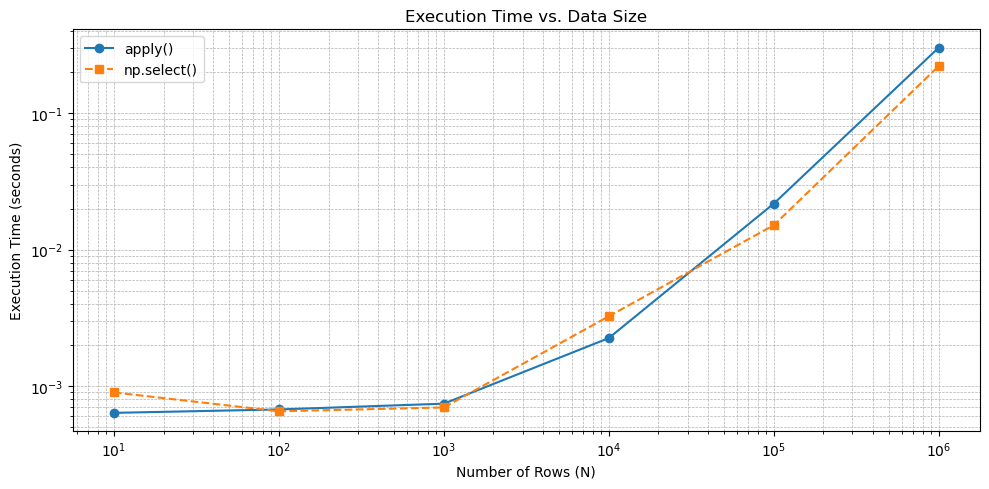

In [9]:
# Executa o benchmark e plota o gráfico
benchmark_plot_apply_vs_npselect(
    sizes=[10**1, 10**2, 10**3, 10**4, 10**5, 10**6],
    figsize=(10, 5),
    log_scale=True
)